# 📊 모델별 SHAP 분석 보고서 (Seoul / WashingtonDC, IQR / no_IQR)
이 노트북은 **이미 학습되어 저장된 단일 모델(LightGBM / XGBoost / RandomForest)** 을 로드해서  
각 모델에 대해 **'모델별 SHAP 해석'** 을 수행하는 보고서형 노트북입니다.

## 목표
- 각 모델(LGBM, XGB, RF)이 **어떤 피처를 중요하게 보며**, **수요(rental_count)를 어떻게 올리고/내리는지** 해석
- **Seoul vs WashingtonDC**, **IQR vs no_IQR** 조건을 바꿔가며 동일한 분석을 재현

> ✅ 주의: SHAP은 **모델이 학습했던 피처 순서/개수**와 동일한 입력이 필요합니다.  
> 이 노트북은 저장된 모델에서 **기대 피처 목록을 추출 → 데이터 컬럼을 자동 정렬/보정**합니다.


## 0) 환경 준비
- Python 3.8 (Apprentice-Project 환경) 기준
- 필요 패키지: `shap`, `lightgbm`, `xgboost`, `scikit-learn`, `pandas`, `numpy`, `matplotlib`, `joblib`

In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
import shap

shap.initjs()


## 1) 프로젝트 루트/경로 자동 탐색
현재 노트북 위치가 `PROJECT-Bicyle-Demand-Forecasting/notebooks/...` 라는 가정 하에  
상위로 올라가며 `models/`, `Data/` 가 있는 폴더를 프로젝트 루트로 인식합니다.

In [16]:
def find_project_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(10):
        if (cur / "models").exists() and (cur / "Data").exists():
            return cur
        cur = cur.parent
    raise RuntimeError("프로젝트 루트를 찾지 못했습니다. (models/, Data/가 있는 상위 폴더에서 실행하세요)")

PROJECT_ROOT = find_project_root(Path.cwd())
PROJECT_ROOT


PosixPath('/home/avg/PROJECT-Bicyle-Demand-Forecasting')

## 2) 분석 대상 선택 (도시/전처리/모델)
- `CITY`: `"seoul"` 또는 `"wdc"`
- `VARIANT`: `"IQR"` 또는 `"no_IQR"`
- `MODEL_KEY`: `"lgbm"` / `"xgb"` / `"rf"`


In [17]:
CITY = "wdc"      # "seoul" | "wdc"
VARIANT = "IQR"     # "IQR" | "no_IQR"
MODEL_KEY = "lgbm"  # "lgbm" | "xgb" | "rf"


## 3) 데이터/모델 경로 규칙 (현재 프로젝트 구조 반영)
- Seoul: `Data/interim/seoul/seoul_rental_data.csv`
- WDC:   `Data/interim/washington/dc_rental_data.csv`
- 모델: `models/IQR/*.pkl`, `models/no_IQR/*.pkl`


In [18]:
def get_data_path(city: str) -> Path:
    if city == "seoul":
        return PROJECT_ROOT / "Data" / "interim" / "seoul" / "seoul_rental_data.csv"
    if city == "wdc":
        return PROJECT_ROOT / "Data" / "interim" / "washington" / "dc_rental_data.csv"
    raise ValueError("CITY must be 'seoul' or 'wdc'")

def get_model_paths(city: str, variant: str) -> dict:
    vdir = PROJECT_ROOT / "models" / variant
    suffix = "" if variant == "IQR" else "_no_iqr"

    if city == "seoul":
        base = "Seoul"
        return {
            "lgbm": vdir / f"{base}_LGBM_all{suffix}.pkl",
            "xgb":  vdir / f"{base}_XGB_all{suffix}.pkl",
            "rf":   vdir / f"{base}_RF_all{suffix}.pkl",
        }
    if city == "wdc":
        base = "WashingtonDC"
        return {
            "lgbm": vdir / f"{base}_LGBM_all{suffix}.pkl",
            "xgb":  vdir / f"{base}_XGB_all{suffix}.pkl",
            "rf":   vdir / f"{base}_RF_all{suffix}.pkl",
        }
    raise ValueError("CITY must be 'seoul' or 'wdc'")

DATA_PATH = get_data_path(CITY)
MODEL_PATHS = get_model_paths(CITY, VARIANT)

DATA_PATH, MODEL_PATHS


(PosixPath('/home/avg/PROJECT-Bicyle-Demand-Forecasting/Data/interim/washington/dc_rental_data.csv'),
 {'lgbm': PosixPath('/home/avg/PROJECT-Bicyle-Demand-Forecasting/models/IQR/WashingtonDC_LGBM_all.pkl'),
  'xgb': PosixPath('/home/avg/PROJECT-Bicyle-Demand-Forecasting/models/IQR/WashingtonDC_XGB_all.pkl'),
  'rf': PosixPath('/home/avg/PROJECT-Bicyle-Demand-Forecasting/models/IQR/WashingtonDC_RF_all.pkl')})

## 4) 데이터 로드 및 전처리 (학습 코드와 연계)
- target: `rental_count`
- 문자열/식별/날짜 컬럼은 제외(수치형 중심)
- WDC의 `quarter of day` → `quarter_flag`로 정규화


In [19]:
TARGET_COL = "rental_count"

def load_dataset(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "quarter of day" in df.columns and "quarter_flag" not in df.columns:
        df = df.rename(columns={"quarter of day": "quarter_flag"})
    return df

df = load_dataset(DATA_PATH)
df.head(), df.shape


(             NAME        lat        lon        date  quarter_flag  month  \
 0  10th & E St NW  38.895914 -77.026064  2021-01-01             3      1   
 1  10th & E St NW  38.895914 -77.026064  2021-01-02             2      1   
 2  10th & E St NW  38.895914 -77.026064  2021-01-02             3      1   
 3  10th & E St NW  38.895914 -77.026064  2021-01-03             2      1   
 4  10th & E St NW  38.895914 -77.026064  2021-01-04             3      1   
 
    weekend  rental_count             used_time(avg)  used_dis(avg)  ...  \
 0        0             1            0 days 00:07:38     991.205593  ...   
 1        1             4     0 days 00:12:09.250000    1647.225478  ...   
 2        1             8     0 days 01:08:14.250000     245.342094  ...   
 3        1             1            0 days 00:02:39     368.148128  ...   
 4        0             7  0 days 00:08:58.714285714    1456.604536  ...   
 
    temperature  humidity windspeed cloud_cover  shortwave_radiation  \
 0    

In [20]:
def build_X_y(df: pd.DataFrame, target_col: str = TARGET_COL):
    if target_col not in df.columns:
        raise KeyError(f"target_col='{target_col}' not in columns")

    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0.0).astype(float)

    X = df.drop(columns=[target_col], errors="ignore").copy()

    # 수치형 컬럼만 사용 (학습 코드 관례)
    X_num = X.select_dtypes(include=["number"]).copy()

    if "quarter_flag" in X_num.columns:
        X_num["quarter_flag"] = pd.to_numeric(X_num["quarter_flag"], errors="coerce").fillna(0).astype(int)

    X_num = X_num.fillna(0.0)
    return X_num, y

X_raw, y = build_X_y(df, TARGET_COL)
X_raw.shape, y.shape


((1402340, 59), (1402340,))

## 5) 모델 로드 & 기대 피처 추출 & 입력 정렬 (핵심)
- 누락 컬럼: 0으로 추가
- 불필요 컬럼: 제거
- 컬럼 순서: 학습 시 기대 순서로 재정렬


In [21]:
def load_model(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"Model not found: {path}")
    return joblib.load(path)

def get_expected_features(model):
    # LightGBM
    if hasattr(model, "booster_"):
        try:
            return list(model.booster_.feature_name())
        except Exception:
            pass
    if hasattr(model, "feature_name_"):
        try:
            return list(model.feature_name_)
        except Exception:
            pass

    # XGBoost sklearn wrapper
    if hasattr(model, "get_booster"):
        try:
            bn = model.get_booster().feature_names
            if bn is not None:
                return list(bn)
        except Exception:
            pass

    # sklearn (RF etc.)
    if hasattr(model, "feature_names_in_"):
        return list(model.feature_names_in_)

    return None

def align_features(X: pd.DataFrame, expected_features):
    X2 = X.copy()
    if expected_features is None:
        return X2

    missing = [c for c in expected_features if c not in X2.columns]
    for c in missing:
        X2[c] = 0.0

    extras = [c for c in X2.columns if c not in expected_features]
    if extras:
        X2 = X2.drop(columns=extras, errors="ignore")

    X2 = X2[expected_features]
    return X2

model = load_model(MODEL_PATHS[MODEL_KEY])
expected = get_expected_features(model)
(len(expected), expected[:5]) if expected is not None else None


(42, ['month', 'weekend', 'quarter_flag', 'CAPACITY', 'n_station_idx'])

In [22]:
X = align_features(X_raw, expected)
X.shape, X_raw.shape


((1402340, 42), (1402340, 59))

## 6) SHAP 계산용 샘플링
데이터가 클 수 있으므로 SHAP은 기본적으로 일부 샘플로 계산합니다.


In [23]:
SAMPLE_N = 5000
X_sample = X.sample(n=min(SAMPLE_N, len(X)), random_state=42)
X_sample.shape


(5000, 42)

## 7) SHAP 계산 및 시각화
- Global 중요도 (bar)
- Summary plot (분포)
- Top-5 dependence plot


In [24]:
def compute_shap_values(model, X_sample: pd.DataFrame):
    explainer = shap.TreeExplainer(model)
    sv = explainer.shap_values(X_sample)
    if isinstance(sv, list):
        sv = sv[0]
    return explainer, sv

explainer, shap_values = compute_shap_values(model, X_sample)
np.array(shap_values).shape


(5000, 42)

### 7.1 Global Feature Importance (Bar)


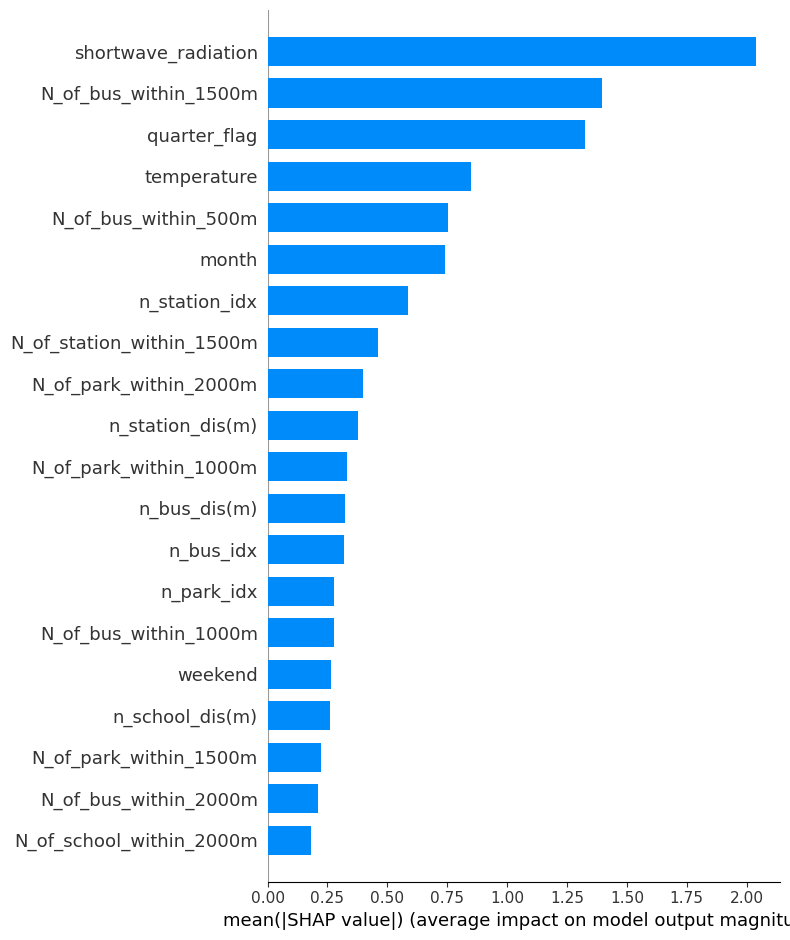

In [25]:
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)


### 7.2 SHAP Summary Plot (Distribution)


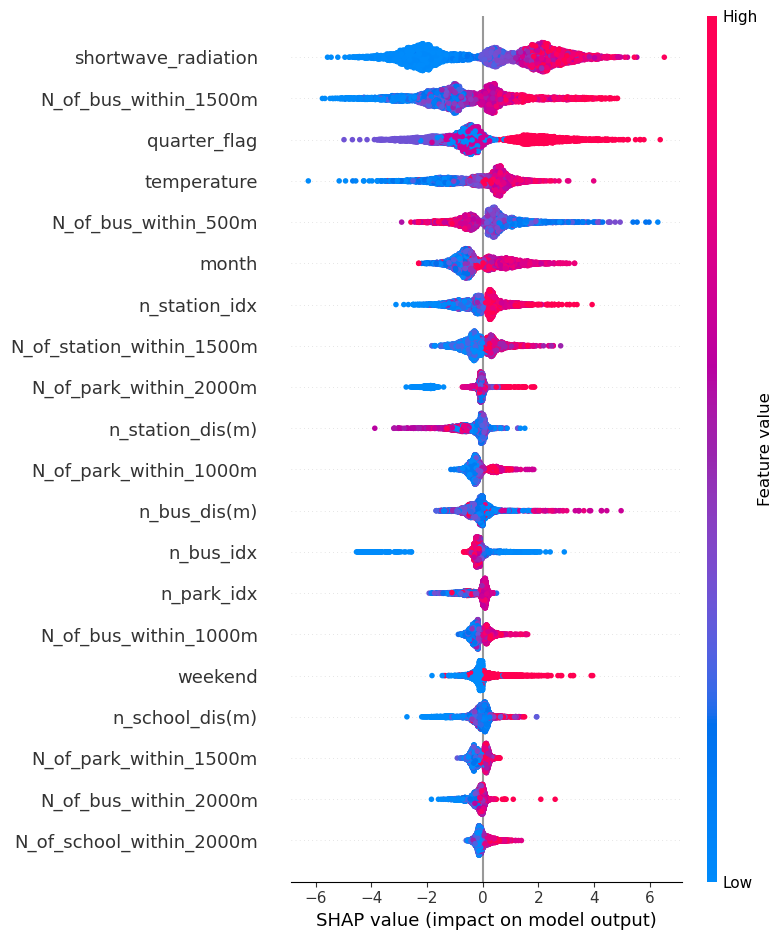

In [26]:
shap.summary_plot(shap_values, X_sample, show=True)


### 7.3 Top-5 Dependence Plot


In [27]:
mean_abs = np.abs(shap_values).mean(axis=0)
top5_idx = np.argsort(mean_abs)[-5:]
top5_features = list(X_sample.columns[top5_idx])
top5_features


['N_of_bus_within_500m',
 'temperature',
 'quarter_flag',
 'N_of_bus_within_1500m',
 'shortwave_radiation']

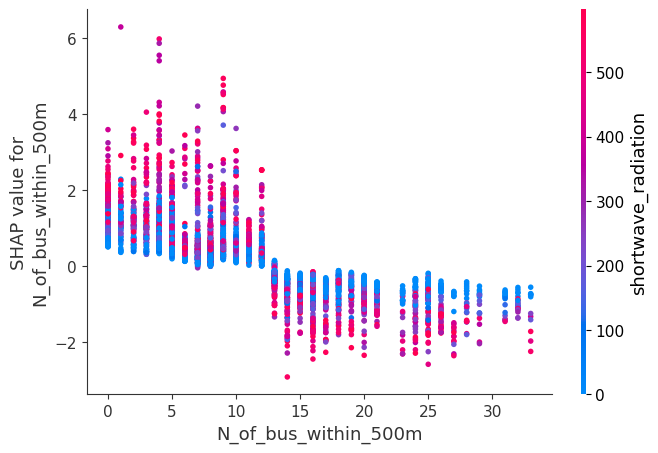

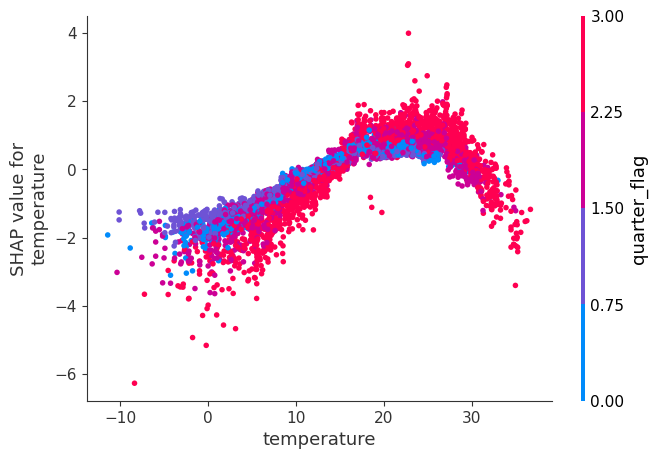

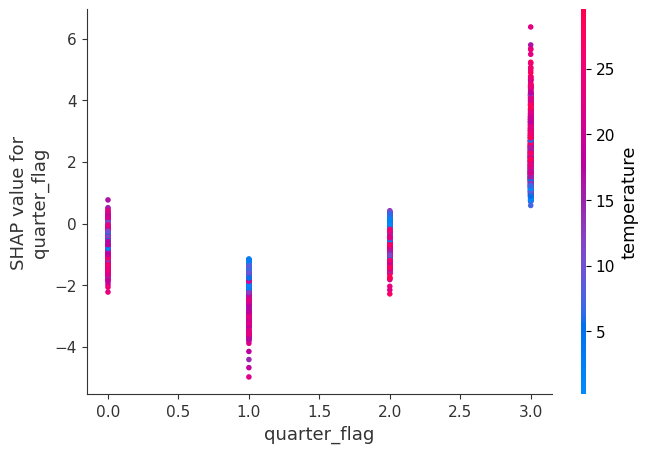

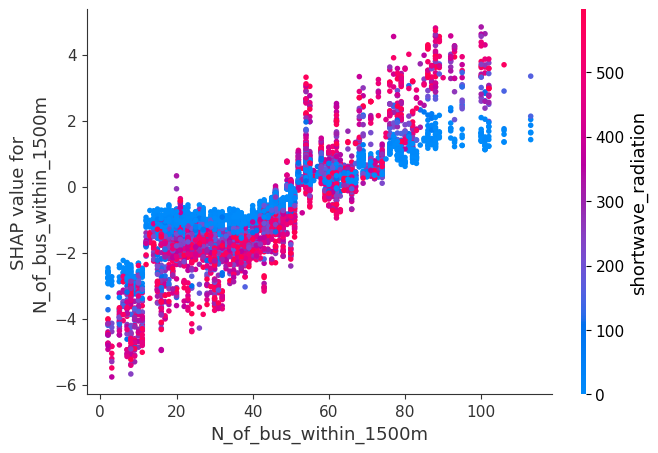

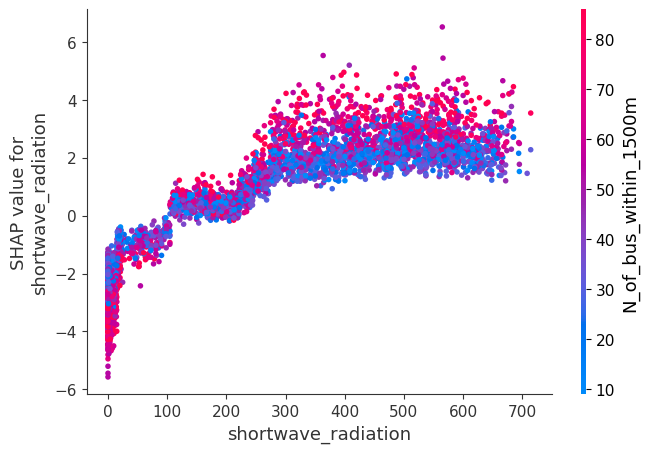

In [28]:
for f in top5_features:
    shap.dependence_plot(f, shap_values, X_sample, show=True)


## 8) 보고서

### 8.1 LightGBM 해석 포인트
- 시간대(`quarter_flag`) 상위: 출퇴근/활동 시간 패턴 반영
- 날씨(`temperature`, `precipitation`, `weathersit`) 상위: 환경 요인 민감
- POI 계열 상위: 입지/공간적 수요 차이 설명력 큼

### 8.2 XGBoost 해석 포인트
- SHAP 분산이 크고 dependence에서 임계점/곡선: 비선형/상호작용 강함
- POI + 날씨 상호작용은 dependence plot의 색 분포로 확인

### 8.3 RandomForest 해석 포인트
- 중요도가 여러 피처에 분산: 평균화 기반 안정성
- 날카로운 임계점보다는 완만한 경향 가능


## 9) 결과 저장
기본은 화면 출력만 수행합니다. 저장이 필요하면 `SAVE_FIGS=True` 로 바꾸세요.


In [29]:
SAVE_FIGS = False
OUT_DIR = PROJECT_ROOT / "shap_result" / f"{CITY}_{VARIANT}_{MODEL_KEY}"
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR =", OUT_DIR)


OUT_DIR = /home/avg/PROJECT-Bicyle-Demand-Forecasting/shap_result/wdc_IQR_lgbm


In [30]:
if SAVE_FIGS:
    # bar plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig(OUT_DIR / "global_importance_bar.png", dpi=200)
    plt.close()

    # summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.tight_layout()
    plt.savefig(OUT_DIR / "summary_plot.png", dpi=200)
    plt.close()

    print("Saved plots to:", OUT_DIR)


---
# ✅ 다음 작업
- MODEL_KEY를 바꿔서 LGBM/XGB/RF 각각의 SHAP 결과를 만든 뒤,
  - 도시별 비교(Seoul vs WDC)
  - IQR vs no_IQR 비교
  - 앙상블 SHAP(근사) 확장
으로 이어갈 수 있습니다.
